<a href="https://colab.research.google.com/github/DrVenkataRajeshKumar/S10/blob/master/S10f.8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [61]:
!git clone https://github.com/DrVenkataRajeshKumar/EVA4Library.git
import sys
sys.path.append("/content/EVA4_LIBRARY/EVA4")

fatal: destination path 'EVA4Library' already exists and is not an empty directory.


In [62]:
!pip install -U git+https://github.com/albu/albumentations > /dev/null && echo "All libraries are successfully installed!"

  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-n7cnsxyj
All libraries are successfully installed!


In [63]:
from torchvision import datasets
train = datasets.CIFAR10('./data', train=True, download=True)

Files already downloaded and verified


In [64]:
from tqdm import tqdm_notebook
from PIL import Image
import numpy as np
n = 0
s = np.zeros(3)
sq = np.zeros(3)
for data, l in tqdm_notebook(train):
  x = np.array(data)/255
  s += x.sum(axis=(0,1))
  sq += np.sum(np.square(x), axis=(0,1))
  n += x.shape[0]*x.shape[1]

mu = s/n
std = np.sqrt((sq/n - np.square(mu)))
print(mu, sq/n, std, n)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys



[0.49139968 0.48215841 0.44653091] [0.30249857 0.29176174 0.26781806] [0.24703223 0.24348513 0.26158784] 51200000


In [0]:
# add path to our library in default search path
import sys
sys.path.append('/content/drive/My Drive/EVA4')

In [0]:

import numpy as np
#import eva4datatransforms as eva4datatransforms
from torchvision import transforms
from eva4albumentations import Albumentations
channel_means = (0.49139968, 0.48215841, 0.44653091)
channel_stdevs = (0.24703223, 0.24348513, 0.26158784)
norm_mean_std=[channel_means,channel_stdevs]
# Train Phase transformations
train_transforms = Albumentations(norm_mean_std,Rotate=(-30,30),HorizontalFlip=True,RGBshift=(50,50,50),cutout=(3,))

# Test Phase transformations
test_transforms = Albumentations(norm_mean_std)

In [67]:
from torchvision import datasets
train = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
import eva4dataloaders

dataloader = eva4dataloaders.DataLoader(batch_size=128)

# train dataloader
train_loader = dataloader.load(train)

# test dataloader
test_loader = dataloader.load(test)

torch.Size([128, 3, 32, 32])
torch.Size([128])


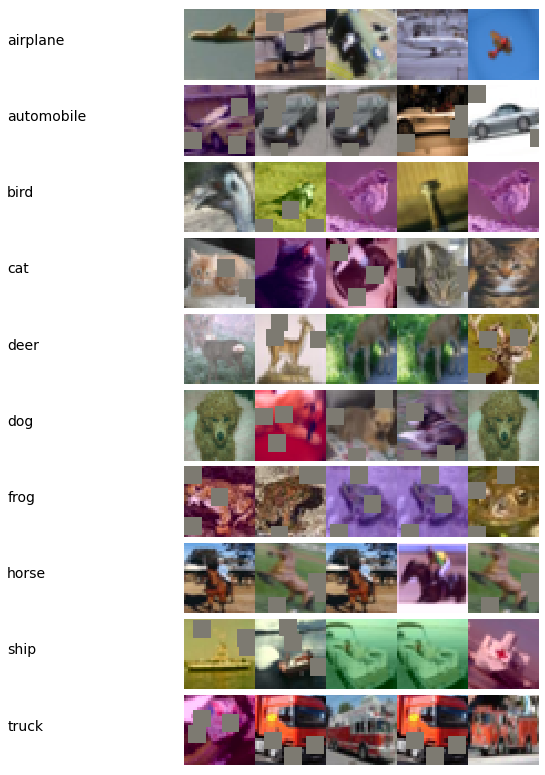

In [69]:
from __future__ import print_function
def unnormalize(img):
  img = img.cpu().numpy().astype(dtype=np.float32)
  
  for i in range(img.shape[0]):
    img[i] = (img[i]*channel_stdevs[i])+channel_means[i]
  
  return np.transpose(img, (1,2,0))

%matplotlib inline
import matplotlib.pyplot as plt
dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

num_classes = 10
# display 10 images from each category. 
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
r, c = 10, 11
n = 5
fig = plt.figure(figsize=(14,14))
fig.subplots_adjust(hspace=0.01, wspace=0.01)
for i in range(num_classes):
    idx = np.random.choice(np.where(labels[:]==i)[0], n)
    ax = plt.subplot(r, c, i*c+1)
    ax.text(-1.5, 0.5, class_names[i], fontsize=14)
    plt.axis('off')
    for j in range(1, n+1):
      plt.subplot(r, c, i*c+j+1)
      plt.imshow(unnormalize(images[idx[j-1]]), interpolation='none')
      plt.axis('off')
plt.show()

In [70]:
import rn
import torch
model = rn.ResNet18()
use_cuda = torch.cuda.is_available()
model.device = torch.device("cuda" if use_cuda else "cpu")
model.to(model.device)
model.summary((3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()



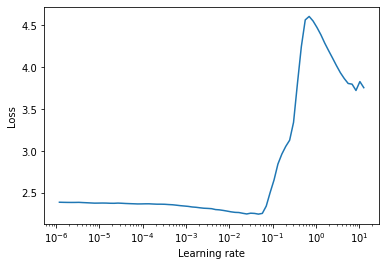

In [71]:
# LR finder fast ai approach
from lrfinder import LRFinder
import torch.optim as optim
import torch.nn as nn
L1lambda = 0
L2lambda = 1e-4
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-7, momentum=0.9, nesterov=True, weight_decay=L2lambda)
lr_finder = LRFinder(model, optimizer, criterion, device=model.device)
lr_finder.range_test(train_loader, end_lr=100, num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [0]:
loss = lr_finder.history['loss']
lr = lr_finder.history['lr']
#lr[loss.index(min(loss))]
optimizer = optim.SGD(model.parameters(), lr=lr[loss.index(min(loss))], momentum=0.9, nesterov=True, weight_decay=L2lambda)

In [73]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
EPOCHS = 50
#scheduler = StepLR(optimizer, step_size=5, gamma=0.5)
#scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.5, steps_per_epoch=len(train_loader), epochs=EPOCHS)

scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.8, patience=1, verbose=True)

model.gotrain(optimizer, train_loader, test_loader, EPOCHS, "/content/drive/My Drive", scheduler, False, L1lambda)


Validation loss decreased (100000.000000 --> 1.496037).  Saving model ...
Epoch: 1, Train set: Average loss: 0.0135, Accuracy: 38.12%; Test set: Average loss: 1.4960, Accuracy: 46.24%
Learning Rate = 0.046774



Validation loss decreased (1.496037 --> 0.991896).  Saving model ...
Epoch: 2, Train set: Average loss: 0.0096, Accuracy: 56.43%; Test set: Average loss: 0.9919, Accuracy: 65.28%
Learning Rate = 0.046774



Epoch     3: reducing learning rate of group 0 to 3.7419e-02.
Validation loss decreased (0.991896 --> 0.814063).  Saving model ...
Epoch: 3, Train set: Average loss: 0.0078, Accuracy: 65.21%; Test set: Average loss: 0.8141, Accuracy: 71.96%
Learning Rate = 0.037419



Validation loss decreased (0.814063 --> 0.656531).  Saving model ...
Epoch: 4, Train set: Average loss: 0.0064, Accuracy: 71.37%; Test set: Average loss: 0.6565, Accuracy: 77.60%
Learning Rate = 0.037419



Epoch     5: reducing learning rate of group 0 to 2.9935e-02.
Validation loss decreased (0.656531 --> 0.642793).  Saving model ...
Epoch: 5, Train set: Average loss: 0.0057, Accuracy: 74.41%; Test set: Average loss: 0.6428, Accuracy: 78.10%
Learning Rate = 0.029935



Validation loss decreased (0.642793 --> 0.549570).  Saving model ...
Epoch: 6, Train set: Average loss: 0.0050, Accuracy: 77.81%; Test set: Average loss: 0.5496, Accuracy: 81.53%
Learning Rate = 0.029935



Epoch     7: reducing learning rate of group 0 to 2.3948e-02.
Epoch: 7, Train set: Average loss: 0.0046, Accuracy: 79.35%; Test set: Average loss: 0.5504, Accuracy: 81.27%
Learning Rate = 0.023948



Validation loss decreased (0.549570 --> 0.492787).  Saving model ...
Epoch: 8, Train set: Average loss: 0.0041, Accuracy: 81.67%; Test set: Average loss: 0.4928, Accuracy: 83.83%
Learning Rate = 0.023948



Epoch     9: reducing learning rate of group 0 to 1.9158e-02.
Validation loss decreased (0.492787 --> 0.451386).  Saving model ...
Epoch: 9, Train set: Average loss: 0.0039, Accuracy: 82.72%; Test set: Average loss: 0.4514, Accuracy: 84.91%
Learning Rate = 0.019158



Validation loss decreased (0.451386 --> 0.404604).  Saving model ...
Epoch: 10, Train set: Average loss: 0.0035, Accuracy: 84.52%; Test set: Average loss: 0.4046, Accuracy: 86.09%
Learning Rate = 0.019158



Epoch    11: reducing learning rate of group 0 to 1.5327e-02.
Epoch: 11, Train set: Average loss: 0.0033, Accuracy: 85.11%; Test set: Average loss: 0.4361, Accuracy: 85.72%
Learning Rate = 0.015327



Validation loss decreased (0.404604 --> 0.400971).  Saving model ...
Epoch: 12, Train set: Average loss: 0.0030, Accuracy: 86.72%; Test set: Average loss: 0.4010, Accuracy: 86.75%
Learning Rate = 0.015327



Epoch    13: reducing learning rate of group 0 to 1.2261e-02.
Validation loss decreased (0.400971 --> 0.373441).  Saving model ...
Epoch: 13, Train set: Average loss: 0.0028, Accuracy: 87.23%; Test set: Average loss: 0.3734, Accuracy: 87.61%
Learning Rate = 0.012261



Validation loss decreased (0.373441 --> 0.352496).  Saving model ...
Epoch: 14, Train set: Average loss: 0.0026, Accuracy: 88.33%; Test set: Average loss: 0.3525, Accuracy: 88.22%
Learning Rate = 0.012261



Epoch    15: reducing learning rate of group 0 to 9.8091e-03.
Validation loss decreased (0.352496 --> 0.344951).  Saving model ...
Epoch: 15, Train set: Average loss: 0.0025, Accuracy: 89.13%; Test set: Average loss: 0.3450, Accuracy: 88.87%
Learning Rate = 0.009809



Validation loss decreased (0.344951 --> 0.343225).  Saving model ...
Epoch: 16, Train set: Average loss: 0.0023, Accuracy: 90.05%; Test set: Average loss: 0.3432, Accuracy: 89.17%
Learning Rate = 0.009809



Epoch    17: reducing learning rate of group 0 to 7.8473e-03.
Epoch: 17, Train set: Average loss: 0.0021, Accuracy: 90.55%; Test set: Average loss: 0.3491, Accuracy: 88.81%
Learning Rate = 0.007847



Epoch: 18, Train set: Average loss: 0.0020, Accuracy: 91.52%; Test set: Average loss: 0.3611, Accuracy: 88.69%
Learning Rate = 0.007847



Epoch    19: reducing learning rate of group 0 to 6.2778e-03.
Validation loss decreased (0.343225 --> 0.328086).  Saving model ...
Epoch: 19, Train set: Average loss: 0.0019, Accuracy: 91.53%; Test set: Average loss: 0.3281, Accuracy: 89.67%
Learning Rate = 0.006278



Validation loss decreased (0.328086 --> 0.314525).  Saving model ...
Epoch: 20, Train set: Average loss: 0.0018, Accuracy: 92.26%; Test set: Average loss: 0.3145, Accuracy: 90.05%
Learning Rate = 0.006278



Epoch    21: reducing learning rate of group 0 to 5.0223e-03.
Validation loss decreased (0.314525 --> 0.312542).  Saving model ...
Epoch: 21, Train set: Average loss: 0.0016, Accuracy: 92.51%; Test set: Average loss: 0.3125, Accuracy: 90.17%
Learning Rate = 0.005022



Epoch: 22, Train set: Average loss: 0.0015, Accuracy: 93.37%; Test set: Average loss: 0.3338, Accuracy: 89.82%
Learning Rate = 0.005022



Epoch    23: reducing learning rate of group 0 to 4.0178e-03.
Epoch: 23, Train set: Average loss: 0.0015, Accuracy: 93.36%; Test set: Average loss: 0.3258, Accuracy: 90.04%
Learning Rate = 0.004018



Epoch: 24, Train set: Average loss: 0.0014, Accuracy: 93.96%; Test set: Average loss: 0.3127, Accuracy: 90.62%
Learning Rate = 0.004018



Epoch    25: reducing learning rate of group 0 to 3.2143e-03.
Validation loss decreased (0.312542 --> 0.308981).  Saving model ...
Epoch: 25, Train set: Average loss: 0.0013, Accuracy: 94.09%; Test set: Average loss: 0.3090, Accuracy: 90.60%
Learning Rate = 0.003214



Epoch: 26, Train set: Average loss: 0.0013, Accuracy: 94.41%; Test set: Average loss: 0.3131, Accuracy: 90.75%
Learning Rate = 0.003214



Epoch    27: reducing learning rate of group 0 to 2.5714e-03.
Validation loss decreased (0.308981 --> 0.307437).  Saving model ...
Epoch: 27, Train set: Average loss: 0.0012, Accuracy: 94.58%; Test set: Average loss: 0.3074, Accuracy: 90.85%
Learning Rate = 0.002571



Validation loss decreased (0.307437 --> 0.302966).  Saving model ...
Epoch: 28, Train set: Average loss: 0.0012, Accuracy: 95.04%; Test set: Average loss: 0.3030, Accuracy: 90.69%
Learning Rate = 0.002571



Epoch    29: reducing learning rate of group 0 to 2.0571e-03.
Epoch: 29, Train set: Average loss: 0.0011, Accuracy: 95.10%; Test set: Average loss: 0.3062, Accuracy: 90.64%
Learning Rate = 0.002057



Validation loss decreased (0.302966 --> 0.298463).  Saving model ...
Epoch: 30, Train set: Average loss: 0.0011, Accuracy: 95.31%; Test set: Average loss: 0.2985, Accuracy: 91.03%
Learning Rate = 0.002057



Epoch    31: reducing learning rate of group 0 to 1.6457e-03.
Epoch: 31, Train set: Average loss: 0.0011, Accuracy: 95.44%; Test set: Average loss: 0.3103, Accuracy: 90.86%
Learning Rate = 0.001646



Epoch: 32, Train set: Average loss: 0.0010, Accuracy: 95.64%; Test set: Average loss: 0.2993, Accuracy: 91.02%
Learning Rate = 0.001646



Epoch    33: reducing learning rate of group 0 to 1.3166e-03.
Validation loss decreased (0.298463 --> 0.296775).  Saving model ...
Epoch: 33, Train set: Average loss: 0.0010, Accuracy: 95.58%; Test set: Average loss: 0.2968, Accuracy: 90.95%
Learning Rate = 0.001317



Validation loss decreased (0.296775 --> 0.294614).  Saving model ...
Epoch: 34, Train set: Average loss: 0.0009, Accuracy: 95.89%; Test set: Average loss: 0.2946, Accuracy: 91.44%
Learning Rate = 0.001317



Epoch    35: reducing learning rate of group 0 to 1.0532e-03.
Epoch: 35, Train set: Average loss: 0.0009, Accuracy: 95.94%; Test set: Average loss: 0.2959, Accuracy: 91.35%
Learning Rate = 0.001053



Validation loss decreased (0.294614 --> 0.294315).  Saving model ...
Epoch: 36, Train set: Average loss: 0.0009, Accuracy: 95.96%; Test set: Average loss: 0.2943, Accuracy: 91.21%
Learning Rate = 0.001053



Epoch    37: reducing learning rate of group 0 to 8.4260e-04.
Epoch: 37, Train set: Average loss: 0.0009, Accuracy: 96.16%; Test set: Average loss: 0.2947, Accuracy: 91.31%
Learning Rate = 0.000843



Validation loss decreased (0.294315 --> 0.291575).  Saving model ...
Epoch: 38, Train set: Average loss: 0.0009, Accuracy: 96.20%; Test set: Average loss: 0.2916, Accuracy: 91.35%
Learning Rate = 0.000843



Epoch    39: reducing learning rate of group 0 to 6.7408e-04.
Epoch: 39, Train set: Average loss: 0.0009, Accuracy: 96.26%; Test set: Average loss: 0.2984, Accuracy: 91.30%
Learning Rate = 0.000674



Epoch: 40, Train set: Average loss: 0.0008, Accuracy: 96.36%; Test set: Average loss: 0.2965, Accuracy: 91.53%
Learning Rate = 0.000674



Epoch    41: reducing learning rate of group 0 to 5.3926e-04.
Epoch: 41, Train set: Average loss: 0.0008, Accuracy: 96.45%; Test set: Average loss: 0.2978, Accuracy: 91.47%
Learning Rate = 0.000539



Epoch: 42, Train set: Average loss: 0.0008, Accuracy: 96.30%; Test set: Average loss: 0.2962, Accuracy: 91.35%
Learning Rate = 0.000539



Epoch    43: reducing learning rate of group 0 to 4.3141e-04.
Epoch: 43, Train set: Average loss: 0.0008, Accuracy: 96.43%; Test set: Average loss: 0.2943, Accuracy: 91.38%
Learning Rate = 0.000431



Epoch: 44, Train set: Average loss: 0.0008, Accuracy: 96.37%; Test set: Average loss: 0.3010, Accuracy: 91.44%
Learning Rate = 0.000431



Epoch    45: reducing learning rate of group 0 to 3.4513e-04.
Epoch: 45, Train set: Average loss: 0.0008, Accuracy: 96.63%; Test set: Average loss: 0.2956, Accuracy: 91.42%
Learning Rate = 0.000345



Epoch: 46, Train set: Average loss: 0.0008, Accuracy: 96.63%; Test set: Average loss: 0.2987, Accuracy: 91.35%
Learning Rate = 0.000345



Epoch    47: reducing learning rate of group 0 to 2.7610e-04.
Epoch: 47, Train set: Average loss: 0.0008, Accuracy: 96.52%; Test set: Average loss: 0.2974, Accuracy: 91.36%
Learning Rate = 0.000276



Epoch: 48, Train set: Average loss: 0.0008, Accuracy: 96.72%; Test set: Average loss: 0.2983, Accuracy: 91.43%
Learning Rate = 0.000276



Epoch    49: reducing learning rate of group 0 to 2.2088e-04.
Epoch: 49, Train set: Average loss: 0.0008, Accuracy: 96.70%; Test set: Average loss: 0.2971, Accuracy: 91.31%
Learning Rate = 0.000221



Epoch: 50, Train set: Average loss: 0.0008, Accuracy: 96.69%; Test set: Average loss: 0.2963, Accuracy: 91.36%
Learning Rate = 0.000221



In [75]:
print(max(model.stats().train_acc))
print(max(model.stats().test_acc))

0.96716
0.9153


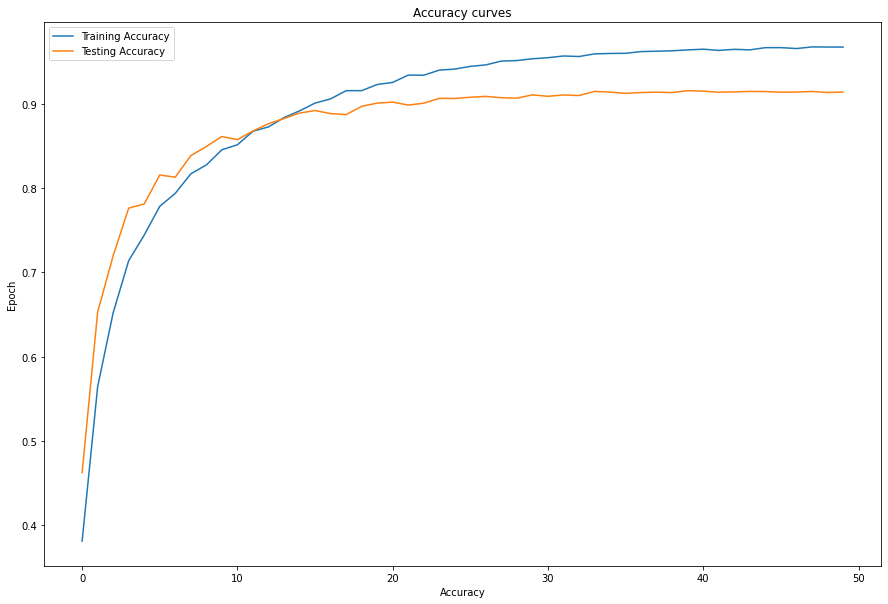

In [76]:
plt.figure(figsize=(15, 10))
ax = plt.subplot(111)
ax.plot(model.stats().train_acc)
ax.plot(model.stats().test_acc)

ax.set(title="Accuracy curves", xlabel="Accuracy", ylabel="Epoch")
ax.legend(['Training Accuracy', 'Testing Accuracy'], loc='best')
plt.savefig("TrainTestAccuracy.png")
plt.show()

In [77]:
len(model.stats().get_misclassified_images())

25

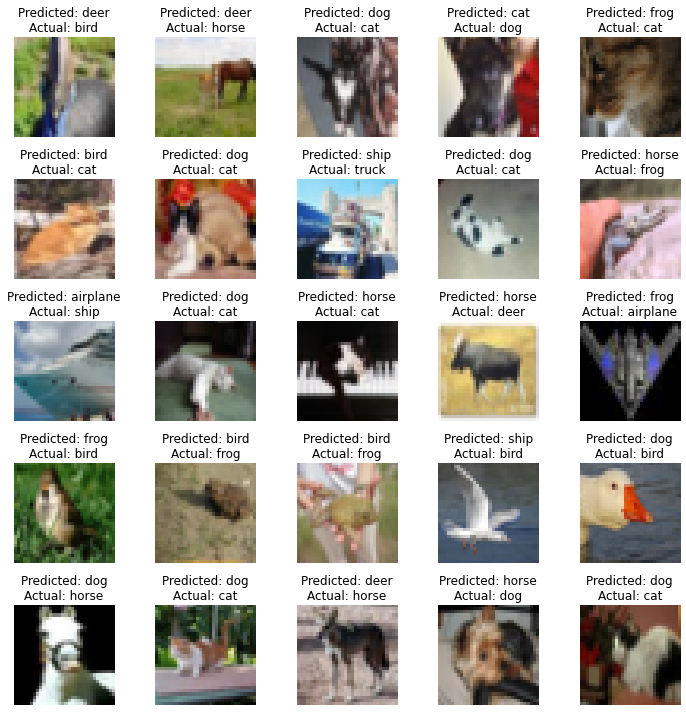

In [78]:
import plots

plots.plot_images(model.stats().get_misclassified_images(), class_names, "misclassified_imgs.png", mean=list(channel_means), std=list(channel_stdevs))

In [0]:
mimages = model.stats().get_misclassified_images()
images = []
target_classes = []
pred_classes = []
for i in mimages:
  images.append(i["img"])
  target_classes.append(int(i['target']))
  pred_classes.append(int(i['pred']))

In [80]:
print(target_classes)
print(pred_classes)

[2, 7, 3, 5, 3, 3, 3, 9, 3, 6, 8, 3, 3, 4, 0, 2, 6, 6, 2, 2, 7, 3, 7, 5, 3]
[4, 4, 5, 3, 6, 2, 5, 8, 5, 7, 0, 5, 7, 7, 6, 6, 2, 2, 8, 5, 5, 5, 4, 7, 5]


In [81]:
model.load_state_dict(torch.load(f"/content/drive/My Drive/{model.name}.pt"))

<All keys matched successfully>

torch.Size([10, 10])
Generating Grad-CAM @layer1
Generating Grad-CAM @layer2
Generating Grad-CAM @layer3
Generating Grad-CAM @layer4


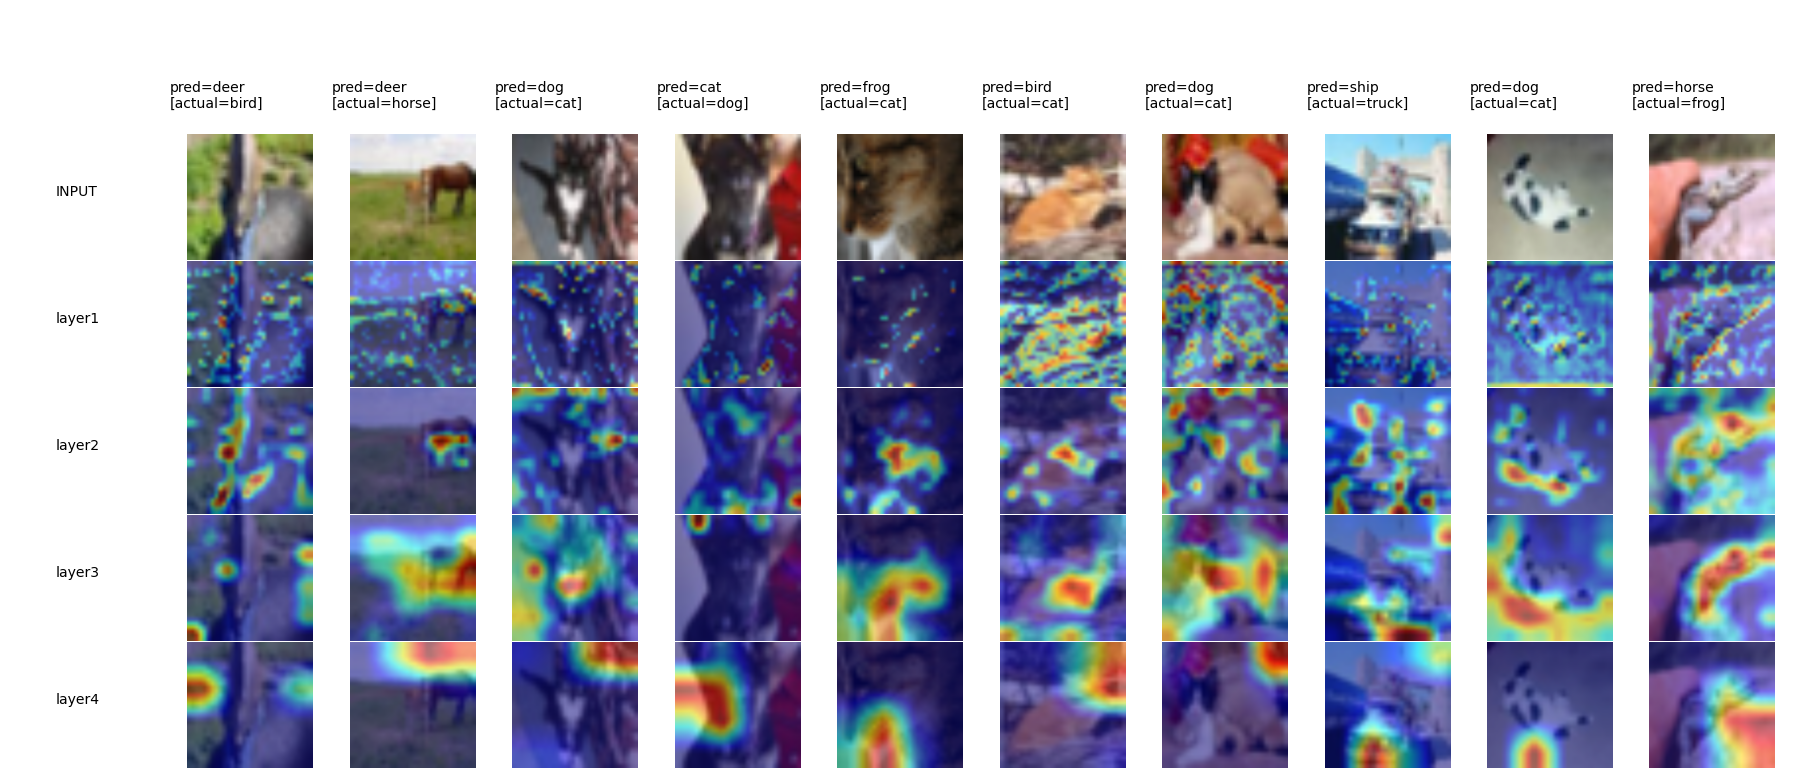

torch.Size([10, 10])
Generating Grad-CAM @layer1
Generating Grad-CAM @layer2
Generating Grad-CAM @layer3
Generating Grad-CAM @layer4


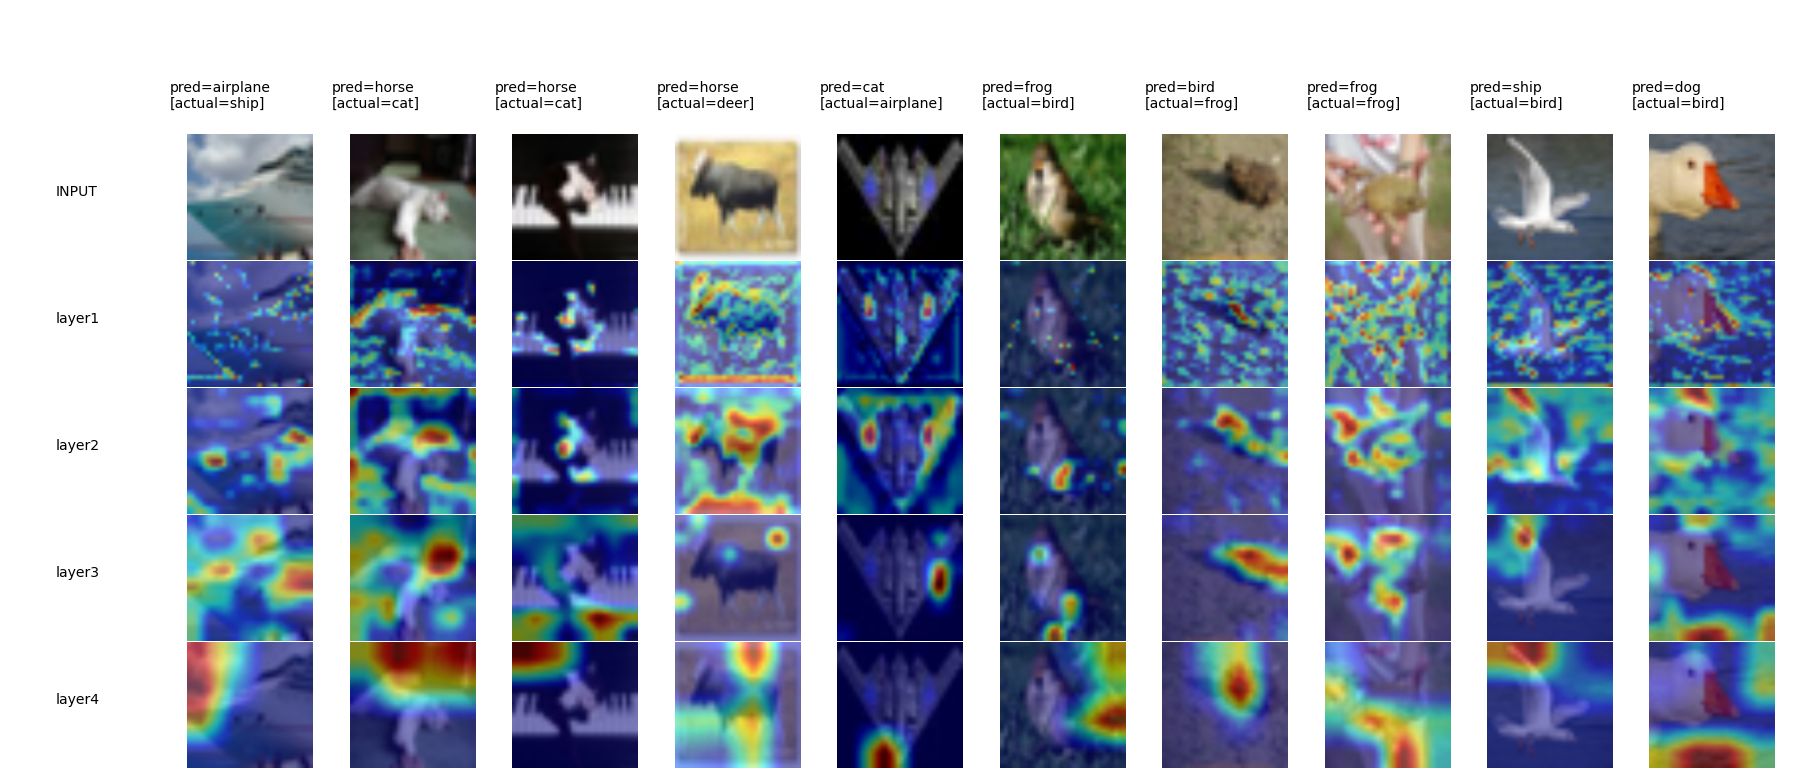

torch.Size([5, 10])
Generating Grad-CAM @layer1
Generating Grad-CAM @layer2
Generating Grad-CAM @layer3
Generating Grad-CAM @layer4


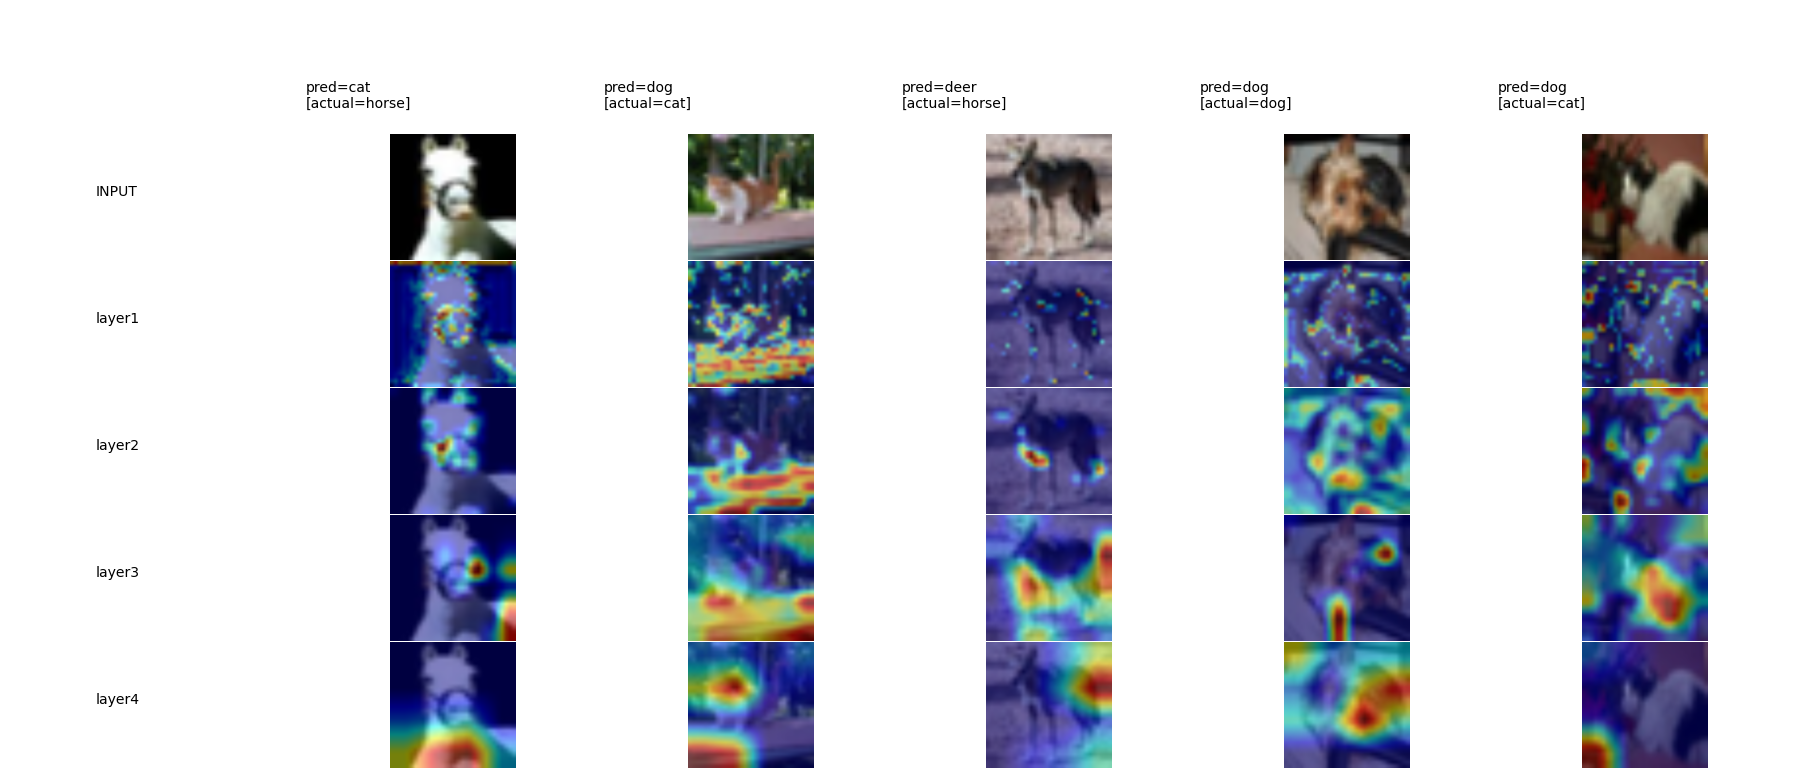

In [82]:
from gradcam import GRADCAM, PLOT
target_layers = ["layer1", "layer2", "layer3", "layer4"]
#Gradcam plot for first 10 misclassified images
gradcam_output, probs, predicted_classes = GRADCAM(images[:10], target_classes[:10], model, target_layers)
PLOT(gradcam_output, images[:10], target_classes[:10], target_layers, class_names, (3, 32, 32), predicted_classes, unnormalize)
#Gradcam plot for 11-20 misclassified images
gradcam_output, probs, predicted_classes = GRADCAM(images[10:20], target_classes[10:20], model, target_layers)
PLOT(gradcam_output, images[10:20], target_classes[10:20], target_layers, class_names, (3, 32, 32), predicted_classes, unnormalize)
#Gradcam plot for 21-25 misclassified images
gradcam_output, probs, predicted_classes = GRADCAM(images[20:], target_classes[20:], model, target_layers)
PLOT(gradcam_output, images[20:], target_classes[20:], target_layers, class_names, (3, 32, 32), predicted_classes, unnormalize)